In [1]:
import asreview
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import synergy_dataset as sd
from asreview.models.balancers import Balanced
from asreview.models.classifiers import NaiveBayes
from asreview.models.feature_extractors import Tfidf
from asreview.models.queriers import Max
from matplotlib.backends.backend_pdf import PdfPages
from scipy.interpolate import interp1d

# Path to your SQLite3 database
db_path = ""

In [2]:
def pad_labels(labels, num_priors, num_records):
    return pd.Series(
        labels.tolist() + np.zeros(num_records - len(labels) - num_priors).tolist()
    )


def n_query_extreme(results, n_records):
    if n_records >= 10000:
        if len(results) >= 10000:
            return 10**5  # finish the run
        if len(results) >= 1000:
            return 1000
        elif len(results) >= 100:
            return 25
        else:
            return 1
    else:
        if len(results) >= 1000:
            return 100
        elif len(results) >= 100:
            return 5
        else:
            return 1

# One Study, One Dataset

In [ ]:
# study = {"dataset_id": "Leenaars_2019", "prior_inclusions": [2579, 16, 27], "prior_exclusions": [1868]}
# study = {"dataset_id": "Meijboom_2021", "prior_inclusions": [531, 434, 129], "prior_exclusions": [119, 437, 362]}
# study = {"dataset_id": "Menon_2022", "prior_inclusions": [392, 744], "prior_exclusions": [197]}
# study = {"dataset_id": "Oud_2018", "prior_inclusions": [162, 256, 626], "prior_exclusions": [669, 866]}
# study = {"dataset_id": "Sep_2021", "prior_inclusions": [160, 124, 42], "prior_exclusions": [178]}
study = {
    "dataset_id": "Donners_2021",
    "prior_inclusions": [6, 235, 48, 81, 65, 98, 147],
    "prior_exclusions": [9],
}
X = sd.Dataset(study["dataset_id"]).to_frame().reset_index()
priors = study["prior_inclusions"] + study["prior_exclusions"]
labels = X["label_included"]

In [ ]:
study_name = "ASReview2-full-tfidf-nb-3"
study = optuna.load_study(study_name=study_name, storage=db_path)
params = study.best_trial.params

alc = asreview.ActiveLearningCycle(
    querier=Max(),
    classifier=NaiveBayes(alpha=params["nb__alpha"]),
    balancer=Balanced(ratio=params["ratio"]),
    feature_extractor=Tfidf(
        stop_words=None,
        ngram_range=(1, 2),
        sublinear_tf=True,
        max_df=params["tfidf__max_df"],
        min_df=params["tfidf__min_df"],
    ),
)
simulate_ndcg = asreview.Simulate(
    X=X,
    labels=labels,
    cycles=[alc],
)
# Set priors
simulate_ndcg.label(priors)
# Start simulation
simulate_ndcg.review()


df_ndcg = simulate_ndcg._results.dropna(axis=0, subset="training_set")
labels_ndcg = pad_labels(df_ndcg["label"].reset_index(drop=True), len(priors), len(X))
recall_ndcg = labels_ndcg.cumsum()

In [ ]:
study_name = "ASReview2-full-nb-1"
study = optuna.load_study(study_name=study_name, storage=db_path)
params = study.best_trial.params

alc = asreview.ActiveLearningCycle(
    querier=Max(),
    classifier=NaiveBayes(alpha=params["alpha"]),
    balancer=Balanced(ratio=params["ratio"]),
    feature_extractor=Tfidf(
        stop_words=None,
        ngram_range=(1, 2),
        sublinear_tf=True,
        max_df=params["tfidf__max_df"],
        min_df=params["tfidf__min_df"],
    ),
)
simulate_loss = asreview.Simulate(
    X=X,
    labels=labels,
    cycles=[alc],
)
# Set priors
simulate_loss.label(priors)
# Start simulation
simulate_loss.review()

df_loss = simulate_loss._results.dropna(axis=0, subset="training_set")
labels_loss = pad_labels(df_loss["label"].reset_index(drop=True), len(priors), len(X))
recall_loss = labels_loss.cumsum()

In [ ]:
alc = asreview.ActiveLearningCycle(
    querier=Max(),
    classifier=NaiveBayes(alpha=3.822),
    balancer=Balanced(ratio=1.2),
    feature_extractor=Tfidf(stop_words="english", ngram_range=(1, 1)),
)
simulate_old = asreview.Simulate(
    X=X,
    labels=labels,
    cycles=[alc],
)
# Set priors
simulate_old.label(priors)
# Start simulation
simulate_old.review()

df_old = simulate_old._results.dropna(axis=0, subset="training_set")
labels_old = pad_labels(df_old["label"].reset_index(drop=True), len(priors), len(X))
recall_old = labels_old.cumsum()

In [ ]:
combined = pd.DataFrame({"loss": recall_loss, "gain": recall_ndcg, "old": recall_old})

combined.plot()
plt.savefig("recall_comp.pdf")

# Mean of Multiple Studies, One Dataset

In [ ]:
dataset_name = "Appenzeller-Herzog_2019"
studies = pd.read_json("synergy_studies_full_val.jsonl", lines=True)
studies = studies[studies["dataset_id"] == dataset_name]
recalls_ndcg = []
recalls_loss = []
recalls_old = []

for _, study in studies.iterrows():
    X = sd.Dataset(study["dataset_id"]).to_frame().reset_index()
    priors = study["prior_inclusions"] + study["prior_exclusions"]
    labels = X["label_included"]
    study_name = "ASReview2-full-tfidf-nb-3"
    study = optuna.load_study(study_name=study_name, storage=db_path)
    params = study.best_trial.params

    alc = asreview.ActiveLearningCycle(
        querier=Max(),
        classifier=NaiveBayes(alpha=params["nb__alpha"]),
        balancer=Balanced(ratio=params["ratio"]),
        feature_extractor=Tfidf(
            stop_words=None,
            ngram_range=(1, 2),
            sublinear_tf=True,
            max_df=params["tfidf__max_df"],
            min_df=params["tfidf__min_df"],
        ),
    )
    simulate_ndcg = asreview.Simulate(
        X=X,
        labels=labels,
        cycles=[alc],
    )
    # Set priors
    simulate_ndcg.label(priors)
    # Start simulation
    simulate_ndcg.review()

    df_ndcg = simulate_ndcg._results.dropna(axis=0, subset="training_set")
    labels_ndcg = pad_labels(
        df_ndcg["label"].reset_index(drop=True), len(priors), len(X)
    )
    recalls_ndcg.append(labels_ndcg.cumsum())

for _, study in studies.iterrows():
    X = sd.Dataset(study["dataset_id"]).to_frame().reset_index()
    priors = study["prior_inclusions"] + study["prior_exclusions"]
    labels = X["label_included"]
    study_name = "ASReview2-full-nb-1"
    study = optuna.load_study(study_name=study_name, storage=db_path)
    params = study.best_trial.params

    alc = asreview.ActiveLearningCycle(
        querier=Max(),
        classifier=NaiveBayes(alpha=params["alpha"]),
        balancer=Balanced(ratio=params["ratio"]),
        feature_extractor=Tfidf(
            stop_words=None,
            ngram_range=(1, 2),
            sublinear_tf=True,
            max_df=params["tfidf__max_df"],
            min_df=params["tfidf__min_df"],
        ),
    )
    simulate_loss = asreview.Simulate(
        X=X,
        labels=labels,
        cycles=[alc],
    )
    # Set priors
    simulate_loss.label(priors)
    # Start simulation
    simulate_loss.review()

    df_loss = simulate_loss._results.dropna(axis=0, subset="training_set")
    labels_loss = pad_labels(
        df_loss["label"].reset_index(drop=True), len(priors), len(X)
    )
    recalls_loss.append(labels_loss.cumsum())

for _, study in studies.iterrows():
    X = sd.Dataset(study["dataset_id"]).to_frame().reset_index()
    priors = study["prior_inclusions"] + study["prior_exclusions"]
    labels = X["label_included"]
    alc = asreview.ActiveLearningCycle(
        querier=Max(),
        classifier=NaiveBayes(alpha=3.822),
        balancer=Balanced(ratio=3),
        feature_extractor=Tfidf(stop_words="english", ngram_range=(1, 1)),
    )
    simulate_old = asreview.Simulate(
        X=X,
        labels=labels,
        cycles=[alc],
    )
    # Set priors
    simulate_old.label(priors)
    # Start simulation
    simulate_old.review()

    df_old = simulate_old._results.dropna(axis=0, subset="training_set")
    labels_old = pad_labels(df_old["label"].reset_index(drop=True), len(priors), len(X))
    recalls_old.append(labels_old.cumsum())

In [ ]:
arrays = [np.array(x) for x in recalls_loss]
new_recalls_loss = [np.mean(k) for k in zip(*arrays)]

arrays = [np.array(x) for x in recalls_ndcg]
new_recalls_ndcg = [np.mean(k) for k in zip(*arrays)]

arrays = [np.array(x) for x in recalls_old]
new_recalls_old = [np.mean(k) for k in zip(*arrays)]

In [ ]:
combined = pd.DataFrame(
    {"loss": new_recalls_loss, "gain": new_recalls_ndcg, "old": new_recalls_old}
)

combined.plot()
plt.savefig(f"recall_comp_{dataset_name}.pdf")

# Mean of Multiple Studies, All Datasets

In [ ]:
studies = pd.read_json("synergy_studies_full_val.jsonl", lines=True)
studies_filtered = (
    studies.sort_values("dataset_id")
    .groupby("dataset_id")
    .head(5)
    .reset_index(drop=True)
)
report_order = studies_filtered["dataset_id"].unique()

## Calculate recalls

### NDCG

In [ ]:
recalls_ndcg = []

opt_study_name = "ASReview2-full-tfidf-nb-3"
opt_study = optuna.load_study(study_name=opt_study_name, storage=db_path)
params = opt_study.best_trial.params
for dataset_name in report_order:
    if dataset_name == "Moran_2021_corrected":
        X = pd.read_csv("./datasets/Moran_2021_corrected_shuffled_raw.csv")
    else:
        X = sd.Dataset(dataset_name).to_frame().reset_index()

    labels = X["label_included"]

    for _, study in studies_filtered[
        studies_filtered["dataset_id"] == dataset_name
    ].iterrows():
        priors = study["prior_inclusions"] + study["prior_exclusions"]

        alc = asreview.ActiveLearningCycle(
            querier=Max(),
            classifier=NaiveBayes(alpha=params["nb__alpha"]),
            balancer=Balanced(ratio=params["ratio"]),
            feature_extractor=Tfidf(
                stop_words=None,
                ngram_range=(1, 2),
                sublinear_tf=True,
                max_df=params["tfidf__max_df"],
                min_df=params["tfidf__min_df"],
            ),
            n_query=lambda results: n_query_extreme(results, X.shape[0]),
        )

        simulate_ndcg = asreview.Simulate(X=X, labels=labels, cycles=[alc])
        simulate_ndcg.label(priors)
        simulate_ndcg.review()

        df_ndcg = simulate_ndcg._results.dropna(axis=0, subset="training_set")
        labels_ndcg = pad_labels(
            df_ndcg["label"].reset_index(drop=True), len(priors), len(X)
        )
        recalls_ndcg.append(labels_ndcg.cumsum())

# Save intermediate results
pd.DataFrame(recalls_ndcg).to_csv("recalls_ndcg.csv", index=False)

### Loss

In [ ]:
recalls_loss = []

opt_study_name = "ASReview2-full-nb-1"
opt_study = optuna.load_study(study_name=opt_study_name, storage=db_path)
params = opt_study.best_trial.params

for dataset_name in report_order:
    if dataset_name == "Moran_2021_corrected":
        X = pd.read_csv("./datasets/Moran_2021_corrected_shuffled_raw.csv")
    else:
        X = sd.Dataset(dataset_name).to_frame().reset_index()

    labels = X["label_included"]

    for _, study in studies_filtered[
        studies_filtered["dataset_id"] == dataset_name
    ].iterrows():
        priors = study["prior_inclusions"] + study["prior_exclusions"]

        alc = asreview.ActiveLearningCycle(
            querier=Max(),
            classifier=NaiveBayes(alpha=params["alpha"]),
            balancer=Balanced(ratio=params["ratio"]),
            feature_extractor=Tfidf(
                stop_words=None,
                ngram_range=(1, 2),
                sublinear_tf=True,
                max_df=params["tfidf__max_df"],
                min_df=params["tfidf__min_df"],
            ),
            n_query=lambda results: n_query_extreme(results, X.shape[0]),
        )

        simulate_loss = asreview.Simulate(X=X, labels=labels, cycles=[alc])
        simulate_loss.label(priors)
        simulate_loss.review()

        df_loss = simulate_loss._results.dropna(axis=0, subset="training_set")
        labels_loss = pad_labels(
            df_loss["label"].reset_index(drop=True), len(priors), len(X)
        )
        recalls_loss.append(labels_loss.cumsum())

# Save intermediate results
pd.DataFrame(recalls_loss).to_csv("recalls_loss.csv", index=False)

### Old Params, ASReview 2.0

In [ ]:
recalls_old = []

for dataset_name in report_order:
    if dataset_name == "Moran_2021_corrected":
        X = pd.read_csv("./datasets/Moran_2021_corrected_shuffled_raw.csv")
    else:
        X = sd.Dataset(dataset_name).to_frame().reset_index()

    labels = X["label_included"]

    for _, study in studies_filtered[
        studies_filtered["dataset_id"] == dataset_name
    ].iterrows():
        priors = study["prior_inclusions"] + study["prior_exclusions"]

        alc = asreview.ActiveLearningCycle(
            querier=Max(),
            classifier=NaiveBayes(alpha=3.822),
            balancer=Balanced(ratio=3),
            feature_extractor=Tfidf(stop_words="english", ngram_range=(1, 1)),
            n_query=lambda results: n_query_extreme(results, X.shape[0]),
        )

        simulate_old = asreview.Simulate(X=X, labels=labels, cycles=[alc])
        simulate_old.label(priors)
        simulate_old.review()

        df_old = simulate_old._results.dropna(axis=0, subset="training_set")
        labels_old = pad_labels(
            df_old["label"].reset_index(drop=True), len(priors), len(X)
        )
        recalls_old.append(labels_old.cumsum())

# Save intermediate results
pd.DataFrame(recalls_old).to_csv("recalls_old.csv", index=False)

## Normalization and Plotting

In [20]:
studies = pd.read_json("synergy_studies_full_val.jsonl", lines=True)
studies_filtered = (
    studies.sort_values("dataset_id")
    .groupby("dataset_id")
    .head(5)
    .reset_index(drop=True)
)

# Load recall CSVs and ensure matching row counts
recall_files = [
    "recalls_ndcg_svm.csv",
    "recalls_loss_svm.csv",
    "recalls_old_nb.csv",
    "recalls_old_1-6_nb.csv",
]
recall_types = ["NDCG", "Loss", "Old2.0", "Old1.6"]

df_ndcg, df_loss, df_old, df_old1_6 = [pd.read_csv(f) for f in recall_files]

# Add dataset name and recall type
for df, recall_type in zip([df_ndcg, df_loss, df_old, df_old1_6], ["NDCG", "Loss", "Old2.0", "Old1.6"]):
    df["dataset_name"] = studies_filtered["dataset_id"].values
    df["Optimization"] = recall_type
    df["prior_inclusions"] = studies_filtered["prior_inclusions"].apply(len)
    df["prior_exclusions"] = studies_filtered["prior_exclusions"].apply(len)

# Combine recall data
df_all = pd.concat([df_ndcg, df_loss, df_old, df_old1_6], ignore_index=True)

# Compute total relevant counts per dataset
total_relevant_dict = {
    dataset_id: pd.read_csv(f"../datasets/{dataset_id}_shuffled_raw.csv")[
        "label_included"
    ].sum()
    if dataset_id == "Moran_2021_corrected"
    else sd.Dataset(dataset_id).to_frame()["label_included"].sum()
    for dataset_id in studies_filtered["dataset_id"].unique()
}

# Melt dataframe
df_all_melted = df_all.melt(
    id_vars=["dataset_name", "Optimization", "prior_inclusions", "prior_exclusions"],
    var_name="step",
    value_name="recall",
).dropna()

# Convert step to numeric
df_all_melted["step"] = df_all_melted["step"].astype(int)

# Calculate total relevant items
df_all_melted["total_relevant"] = df_all_melted["dataset_name"].map(total_relevant_dict)

# Recall normalization
df_all_melted["relative_recall"] = df_all_melted["recall"] / (
    df_all_melted["total_relevant"] - df_all_melted["prior_inclusions"]
)

# Normalize step values to a common scale [0,1]
df_all_melted["relative_step"] = df_all_melted.groupby(["dataset_name", "Optimization"])[
    "step"
].transform(lambda x: x / x.max())

# Interpolation of normalized recall to a common x-axis
x_new = np.linspace(0, 1, 1000)  # 1000 evenly spaced points for smooth curves


interpolated_data = []
for (dataset, recall_type), group in df_all_melted.groupby(["dataset_name", "Optimization"]):
    group = (
        group.sort_values("relative_step")
        .groupby("relative_step", as_index=False)["relative_recall"]
        .mean()
    )

    x, y = group["relative_step"].values, group["relative_recall"].values
    f = interp1d(x, y, kind="linear", fill_value="extrapolate")
    y_new = f(x_new)

    interpolated_data.extend(
        {
            "dataset_name": dataset,
            "Optimization": recall_type,
            "relative_step": step,
            "relative_recall": recall,
        }
        for step, recall in zip(x_new, y_new)
    )

# Create DataFrame from interpolated results
df_interpolated = pd.DataFrame(interpolated_data)

# Compute the mean recall per dataset and recall type
df_grouped = (
    df_all_melted.groupby(["dataset_name", "Optimization", "relative_step"])["relative_recall"]
    .mean()
    .reset_index()
)

In [19]:
# Define grid size
rows, cols = 5, 5
datasets = df_grouped["dataset_name"].unique()

# Create PDF to store all plots
with PdfPages("recall_comparison_nb.pdf") as pdf:
    fig, axes = plt.subplots(rows, cols, figsize=(20, 20))  # Adjust figure size
    axes = axes.flatten()  # Flatten for easy iteration

    for i, dataset in enumerate(datasets):
        ax = axes[i]  # Get subplot axis
        df_subset = df_grouped[df_grouped["dataset_name"] == dataset]

        # Plot mean recall with standard deviation as shaded area
        sns.lineplot(
            data=df_subset,
            x="relative_step",
            y="relative_recall",
            hue="Optimization",
            ax=ax,
            legend=True,
        )

        ax.set_xlabel("Proportion of Documents")
        ax.set_ylabel("Mean Recall")
        ax.set_title(f"{dataset}")

    # Adjust layout and save
    plt.suptitle("Mean Relative Recalls of Naive Bayes per SYNERGY Dataset")
    plt.tight_layout(rect=[0, 0.03, 1, 0.99])
    pdf.savefig(fig)  # Save the entire grid as one page in the PDF
    plt.close(fig)  # Close figure to free memory


In [6]:
# Pivot to get recalls side by side for each type
df_pivot = df_grouped.pivot(index=["dataset_name", "relative_step"], columns="type", values="relative_recall").reset_index()

# Compute pairwise differences
df_pivot["ndcg_minus_old"] = df_pivot["NDCG"] - df_pivot["Old"]
df_pivot["loss_minus_old"] = df_pivot["Loss"] - df_pivot["Old"]
df_pivot["ndcg_minus_loss"] = df_pivot["NDCG"] - df_pivot["Loss"]

# Optional: Compute relative improvement
df_pivot["ndcg_over_old"] = (df_pivot["NDCG"] - df_pivot["Old"]) / df_pivot["Old"]
df_pivot["loss_over_old"] = (df_pivot["Loss"] - df_pivot["Old"]) / df_pivot["Old"]
df_pivot["ndcg_over_loss"] = (df_pivot["NDCG"] - df_pivot["Loss"]) / df_pivot["Loss"]

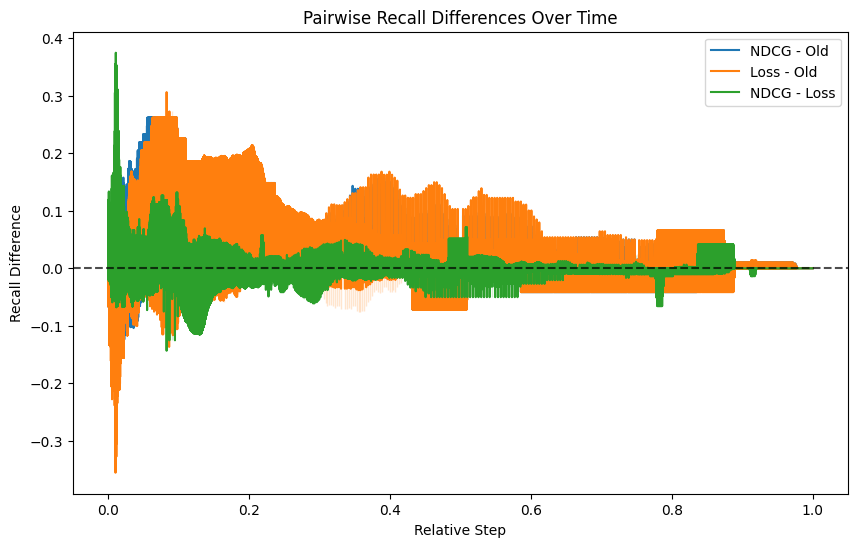

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.lineplot(data=df_pivot, x="relative_step", y="ndcg_minus_old", label="NDCG - Old")
sns.lineplot(data=df_pivot, x="relative_step", y="loss_minus_old", label="Loss - Old")
sns.lineplot(data=df_pivot, x="relative_step", y="ndcg_minus_loss", label="NDCG - Loss")

plt.axhline(0, color="black", linestyle="--", alpha=0.7)  # Baseline
plt.xlabel("Relative Step")
plt.ylabel("Recall Difference")
plt.title("Pairwise Recall Differences Over Time")
plt.legend()
plt.show()


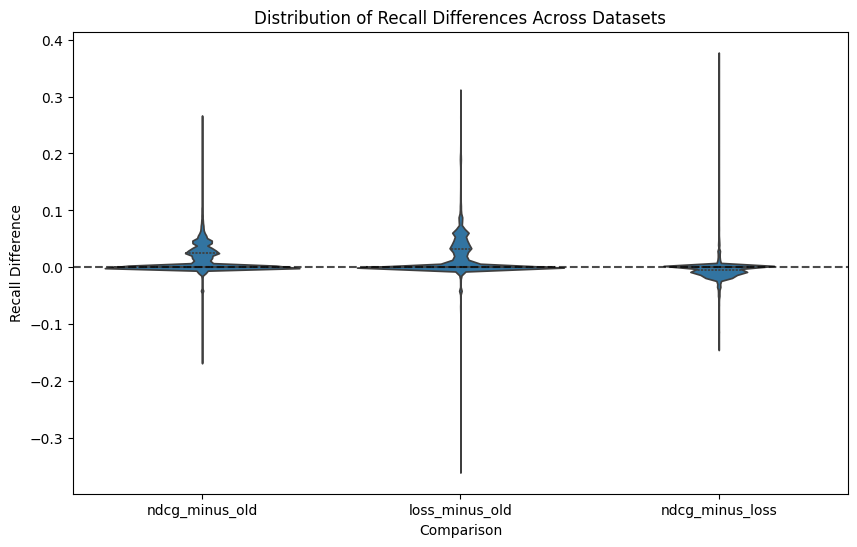

In [8]:
plt.figure(figsize=(10, 6))
df_melted = df_pivot.melt(id_vars=["dataset_name"], 
                          value_vars=["ndcg_minus_old", "loss_minus_old", "ndcg_minus_loss"], 
                          var_name="Comparison", 
                          value_name="Recall Difference")

sns.violinplot(data=df_melted, x="Comparison", y="Recall Difference", inner="quartile")

plt.axhline(0, color="black", linestyle="--", alpha=0.7)  # Baseline
plt.ylabel("Recall Difference")
plt.title("Distribution of Recall Differences Across Datasets")
plt.show()


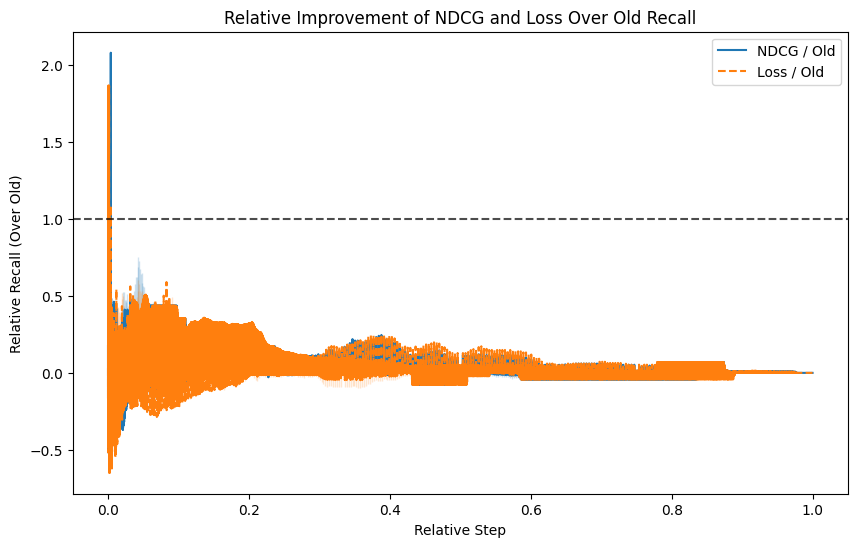

In [ ]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_pivot, x="relative_step", y="ndcg_over_old", label="NDCG / Old", linestyle="-")
sns.lineplot(data=df_pivot, x="relative_step", y="loss_over_old", label="Loss / Old", linestyle="--")

plt.axhline(1, color="black", linestyle="--", alpha=0.7)  # Baseline (no improvement)
plt.xlabel("Relative Step")
plt.ylabel("Relative Recall (Over Old)")
plt.title("Relative Improvement of NDCG and Loss Over Old Recall")
plt.legend()
plt.show()


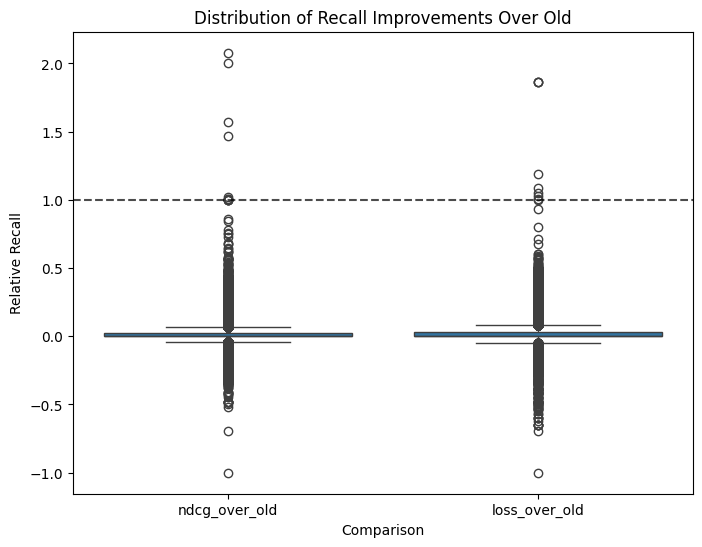

In [10]:
plt.figure(figsize=(8, 6))
df_melted = df_pivot.melt(id_vars=["dataset_name"], 
                          value_vars=["ndcg_over_old", "loss_over_old"], 
                          var_name="Comparison", 
                          value_name="Relative Recall")

sns.boxplot(data=df_melted, x="Comparison", y="Relative Recall")

plt.axhline(1, color="black", linestyle="--", alpha=0.7)  # Baseline (no improvement)
plt.ylabel("Relative Recall")
plt.title("Distribution of Recall Improvements Over Old")
plt.show()


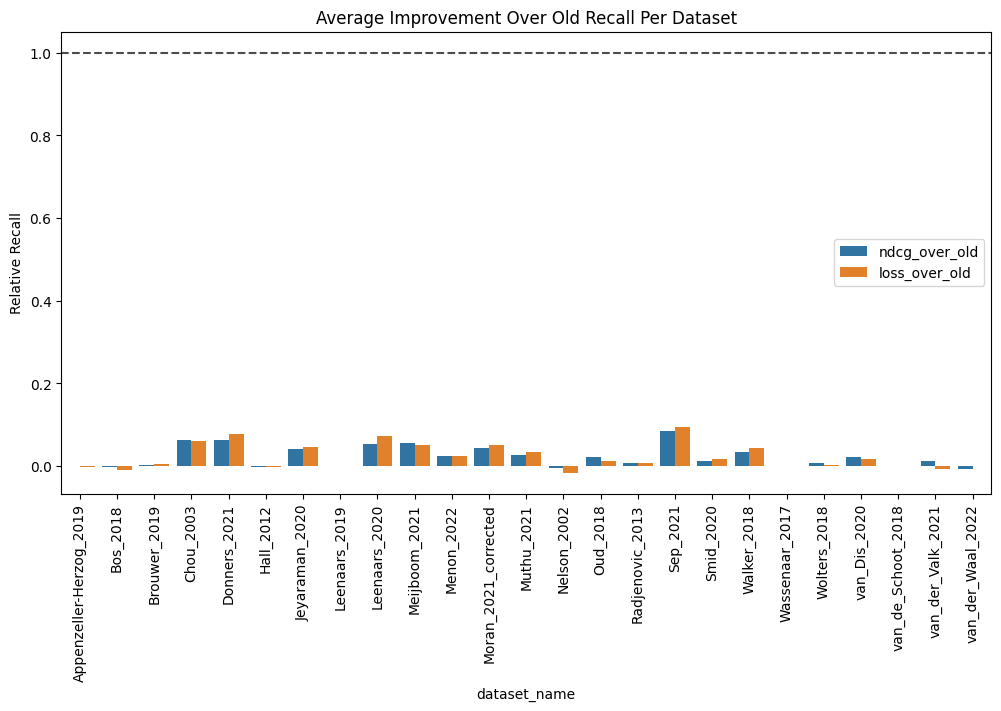

In [12]:
df_avg = df_pivot.groupby("dataset_name")[["ndcg_over_old", "loss_over_old"]].mean().reset_index()

plt.figure(figsize=(12, 6))
df_avg_melted = df_avg.melt(id_vars=["dataset_name"], value_vars=["ndcg_over_old", "loss_over_old"], 
                            var_name="Comparison", value_name="Relative Recall")

sns.barplot(data=df_avg_melted, x="dataset_name", y="Relative Recall", hue="Comparison")

plt.axhline(1, color="black", linestyle="--", alpha=0.7)  # Baseline (no improvement)
plt.xticks(rotation=90)
plt.ylabel("Relative Recall")
plt.title("Average Improvement Over Old Recall Per Dataset")
plt.legend()
plt.show()
